In [39]:
import pandas as pd
import numpy as np
from fastapi import FastAPI,  HTTPException
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
rows = []
with open("steam_games.json") as file:
    for line in file.readlines():
        rows.append(ast.literal_eval(line))

In [33]:
df = pd.DataFrame(rows)

In [34]:
df['release_date'] = pd.to_datetime(df["release_date"], errors='coerce')

In [35]:
df['release_date'] = df.release_date.dt.strftime('%Y-%m-%d')

Valores nulos del dataframe

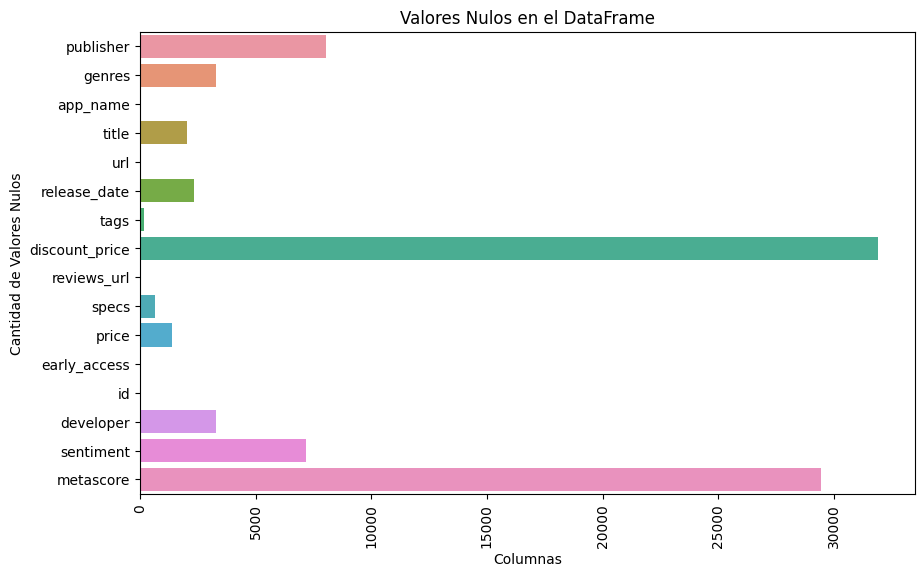

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df.isna().sum(), y=df.columns)
plt.xticks(rotation=90)
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Valores Nulos en el DataFrame')
plt.show()

Eliminamos columnas innecesarias

In [41]:
df = df.drop(['publisher','url', 'tags','title' ,'discount_price', 'reviews_url','id','developer'], axis=1)

Exportamos

In [22]:
df.to_json('nuevos_datos.json')

Leemos el nuevo json y creamos las funciones

In [23]:
df_limpio = pd.read_json('nuevos_datos.json')

In [24]:
df_limpio['release_date'] = pd.to_datetime(df_limpio["release_date"], errors='coerce')
df_limpio['metascore'] = pd.to_numeric(df_limpio['metascore'], errors='coerce')

In [25]:
app = FastAPI(title='Proyecto de Machine Learning Operations de juegos de Steam')

In [26]:
@app.get('/genero/{anio}')
def genero(anio):
   # Filtrar los registros del año ingresado
    df_anio = df_limpio[df_limpio['release_date'].dt.year == int(anio)]

    # Contar la frecuencia de cada género
    generos_contados = df_anio['genres'].explode().value_counts()

    # Tomar los 5 géneros más vendidos
    top_generos = generos_contados.head(5)

    # Obtener la lista de géneros junto con su posición en la lista
    top_generos_con_posicion = [(posicion + 1, genero) for posicion, genero in enumerate(top_generos.index)]

    return top_generos_con_posicion

In [28]:
genero(2018)

[(1, 'Indie'),
 (2, 'Action'),
 (3, 'Adventure'),
 (4, 'Casual'),
 (5, 'Simulation')]

In [27]:
@app.get('/juegos/{anio}')
def juegos(anio):
    try:
        # Validar que el año sea un valor numérico válido
        anio_entero = int(anio)
    except ValueError:
        raise HTTPException(status_code=400, detail='El año proporcionado no es válido.')

    # Filtrar los registros del año ingresado
    df_anio = df_limpio[df_limpio['release_date'].dt.year == anio_entero]

    if df_anio.empty:
        raise HTTPException(status_code=404, detail='No se encontraron juegos para el año proporcionado.')

    # Obtener los juegos lanzados en ese año
    juegos_lanzados = df_anio['app_name'].tolist()

    return juegos_lanzados

In [34]:
juegos(2018)

['Lost Summoner Kitty',
 'Ironbound',
 'Battle Royale Trainer',
 'SNOW - All Access Basic Pass',
 'SNOW - All Access Pro Pass',
 'SNOW - All Access Legend Pass',
 'Race',
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition',
 'Beach Rules',
 'Planetarium 2 - Zen Odyssey',
 'The first thrust of God',
 'SNOW - Starter Pack',
 'The first thrust of God - All Aircrafts',
 'SNOW - Lifetime Pack',
 'The Warrior Of Treasures',
 'DinoBlaster',
 'Robotpencil Presents: Understanding 3D for Concept',
 'Lost Cities',
 'Twisted Enhanced Edition',
 'Vaporwave Simulator',
 'Tactics Forever',
 'Underdone - Soundtrack',
 'Bitcoin Clicker',
 'Darkness and a Crowd',
 'Shotgun Legend',
 'My Time At Portia',
 'Watch Me Jump',
 'Epic Cards Battle 2-Dragons Rising(TCG)',
 'HORDE ATTACK',
 'MagiCat Original Soundtrack',
 'Dark Devotion',
 'INTERSTELLAR PRIME',
 'Reality Incognita',
 'Island Build Masters',
 'A Near Dawn',
 'Fresh Body: Original Soundtrack',
 "Devil's Land",
 'Night

In [28]:
@app.get('/specs/{anio}')
def specs(anio):
    try:
        # Validar que el año sea un valor numérico válido
        anio_entero = int(anio)
    except ValueError:
        raise HTTPException(status_code=400, detail='El año proporcionado no es válido.')

    # Filtrar los registros del año ingresado
    df_anio = df_limpio[df_limpio['release_date'].dt.year == anio_entero]

    if df_anio.empty:
        raise HTTPException(status_code=404, detail='No se encontraron juegos para el año proporcionado.')

    # Contar las especificaciones más comunes
    specs_contados = df_anio['specs'].explode().value_counts()

    # Obtener las 5 especificaciones más comunes junto con su posición
    top_specs = specs_contados.head(5)
    top_specs_con_posicion = [(posicion + 1, espec) for posicion, espec in enumerate(top_specs.index)]

    return top_specs_con_posicion

In [39]:
specs(2000)

[(1, 'Single-player'),
 (2, 'Multi-player'),
 (3, 'Captions available'),
 (4, 'Steam Cloud'),
 (5, 'Steam Trading Cards')]

In [29]:
@app.get('/earlyaccess/{anio}')
def earlyaccess(anio):
    try:
        # Validar que el año sea un valor numérico válido
        anio_entero = int(anio)
    except ValueError:
        raise HTTPException(status_code=400, detail='El año proporcionado no es válido.')

    # Filtrar los registros del año ingresado y que estén en early access
    df_anio_early_access = df_limpio[(df_limpio['release_date'].dt.year == anio_entero) & (df_limpio['early_access'] == True)]

    if df_anio_early_access.empty:
        raise HTTPException(status_code=404, detail='No se encontraron juegos en early access para el año proporcionado.')

    # Obtener la cantidad de juegos en early access
    cantidad_early_access = df_anio_early_access.shape[0]

    return cantidad_early_access

In [30]:
@app.get('/sentiment/{anio}')
def sentiment(anio):
    try:
        # Validar que el año sea un valor numérico válido
        anio_entero = int(anio)
    except ValueError:
        raise HTTPException(status_code=400, detail='El año proporcionado no es válido.')

    # Filtrar los registros del año ingresado
    df_anio = df_limpio[df_limpio['release_date'].dt.year == anio_entero]

    if df_anio.empty:
        raise HTTPException(status_code=404, detail='No se encontraron registros para el año proporcionado.')

    # Obtener el conteo de las categorías de sentimiento
    conteo_categorias = df_anio['sentiment'].value_counts()

    return conteo_categorias.to_dict()

In [31]:
@app.get('/metascore/{anio}')
def metascore(anio):
    try:
        # Validar que el año sea un valor numérico válido
        anio_entero = int(anio)
    except ValueError:
        raise HTTPException(status_code=400, detail='El año proporcionado no es válido.')

    # Filtrar los registros del año ingresado
    df_anio = df_limpio[df_limpio['release_date'].dt.year == anio_entero]

    if df_anio.empty:
        raise HTTPException(status_code=404, detail='No se encontraron registros para el año proporcionado.')

    # Ordenar los juegos por su puntaje (metascore) en orden descendente
    df_ordenado = df_anio.sort_values(by='metascore', ascending=False)

    # Tomar los 5 juegos con mayor puntaje
    top_5_juegos = df_ordenado.head(5)

    return top_5_juegos[['app_name', 'metascore']].to_dict(orient='records')